In [1]:
%matplotlib notebook
import numpy as np
from numba import njit
import matplotlib.pyplot as plt
from HydroWeno.Weno import reconstruct_weno
from scipy.special import gamma
from scipy.optimize import newton_krylov
from tqdm import tqdm_notebook as tqdm
import time

/Users/goobley/MethodologicalValidation/HydroWeno/Weno.py:42: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (array(float64, 1d, A), array(float64, 1d, C))
  enoIntpL[s] = np.dot(q[row, gridIdx:gridIdx+3], EnoCoeffL[2-s])
/Users/goobley/MethodologicalValidation/HydroWeno/Weno.py:43: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (array(float64, 1d, A), array(float64, 1d, C))
  enoIntpR[s] = np.dot(q[row, gridIdx:gridIdx+3], EnoCoeffR[s])


# Smooth Non-Linear Heat Conduction Problem

Presented in [Rempel 2016](http://doi.org/10.3847/1538-4357/834/1/10).

In [2]:
grid = np.linspace(0, 1, 257)
temp = 0.1 + 0.9 * grid**5
dx = grid[1] - grid[0]

In [3]:
@njit('float64[:](float64[:],float64)')
def compute_rempel_source(temperature, beta):
    source = np.zeros_like(grid)
    
    padded = np.zeros((1, temperature.shape[0] + 4))
    padded[0, 2:-2] = temperature
    padded[0, :2] = temperature[0]
    padded[0, -2:] = temperature[-1]
    tTilde = reconstruct_weno(padded)
    tTilde = tTilde[0, :, 2:-2]
    
    source[1:-1] = 1 / dx**2 * (tTilde[1,1:-1]**beta * 
                             (temperature[2:] - temperature[1:-1]) - 
                             tTilde[0,1:-1]**beta * 
                             (temperature[1:-1] - temperature[0:-2]))
    source[1:-1] += 1 / dx**2 * (tTilde[0,2:]**beta * 
                             (temperature[2:] - temperature[1:-1]) - 
                             tTilde[1,0:-2]**beta * 
                             (temperature[1:-1] - temperature[0:-2]))
    source *= 0.5

    return source

In [4]:
temps = [temp]
Theta = 0.55
dt = 1e-2
currentTime = 0
start = time.time()
steps = int(np.ceil(1.0 / dt))
for s in tqdm(range(steps)):
#     print(currentTime)
    prevTemp = np.copy(temps[-1])
    
    def residual(temp):
        dPlus = compute_rempel_source(temp, 2.5)
        d = compute_rempel_source(prevTemp, 2.5)

        return temp - prevTemp - dt * ((Theta)*dPlus + (1.0 - Theta)*d)
    
    newTemp = newton_krylov(residual, prevTemp, f_rtol=1e-7)
    temps.append(newTemp)
    currentTime += dt
end = time.time()
print('Time taken: %f s, per step: %f s' % (end - start, (end-start)/(len(temps)-1)))


Time taken: 17.167563 s, per step: 0.171676 s


<IPython.core.display.Javascript object>


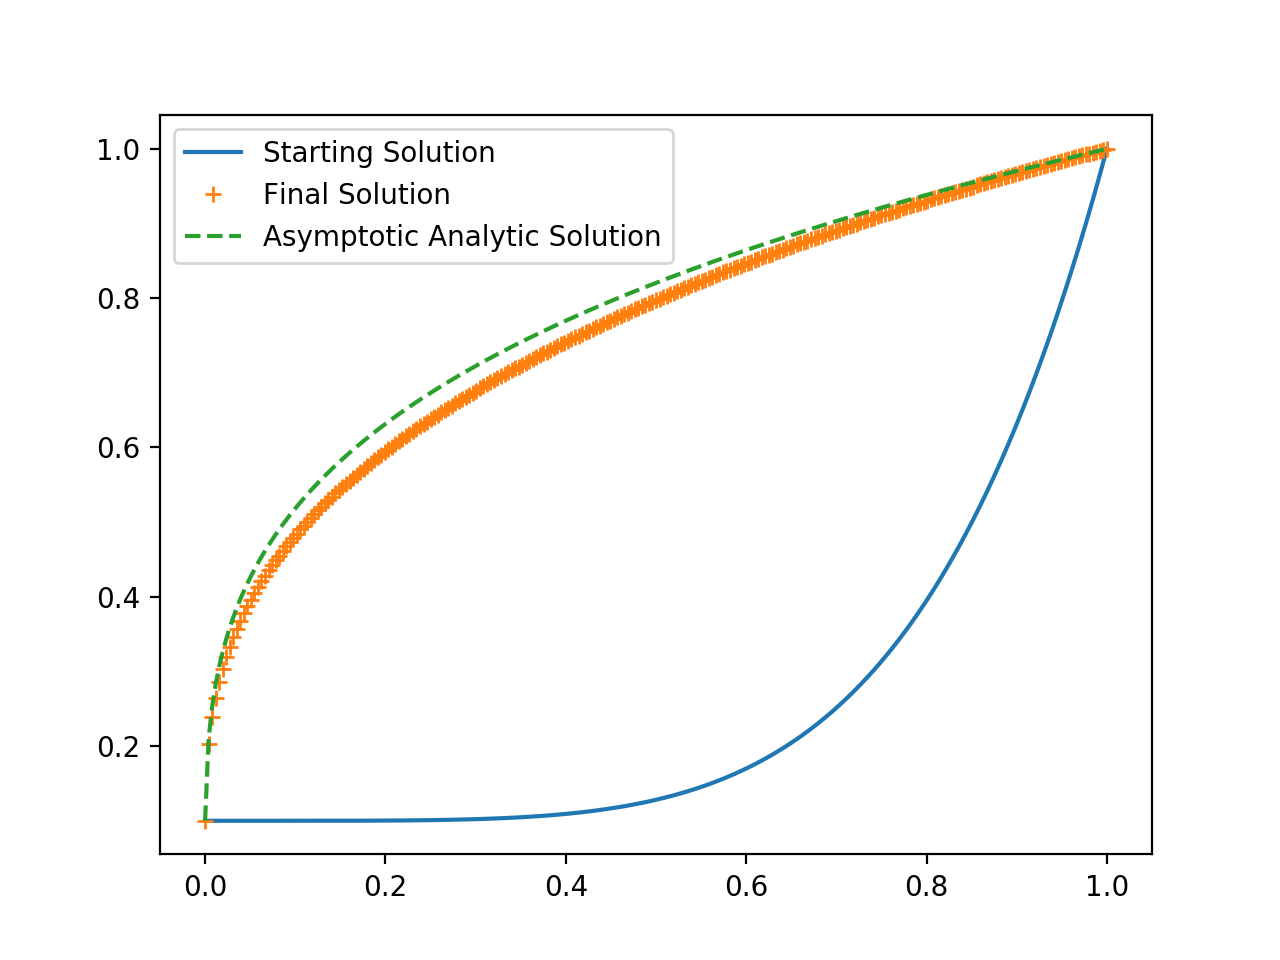

In [5]:
plt.figure()
plt.plot(grid, temps[0], label='Starting Solution')
plt.plot(grid, temps[-1], '+', label='Final Solution')
finalTemp = (0.1**3.5 + (1 - 0.1**3.5)*grid)**(2/7)
plt.plot(grid, finalTemp, '--', label='Asymptotic Analytic Solution')
plt.legend()

# Barenblatt Problem

Solution of the non-linear, non-dimensionalised Barenblatt problem presented in [Viallet et al 2011](http://doi.org/10.1051/0004-6361/201016374) (A.2.2). As this problem is represented by an infinitely fine pile of energy at $\bar{t}=0$ s we choose to use $\bar{t}=0.1$ s as our starting solution.

In [6]:
def barenblatt(alpha, beta, Q, x, t):
    xi0 = ((beta+2)**(beta+1) * 2**(1-beta) / (beta * np.pi**(0.5*beta)) * gamma(0.5 + 1/beta) / gamma(1/beta))**(1/(beta+2))
    f = lambda xi: np.where(np.abs(xi) < xi0, beta * xi0**2 / (2 * (beta+2))**(1/beta)*(1-(xi/xi0)**2)**(1/beta), 0)
    temp = (Q**2/(alpha*t))**(1/(beta+2)) * f(x / (alpha * Q**beta * t))
    return temp

def barenblatt_nondim(beta, x, t):
    temp = t**(-1/(beta+2))
    a = (1-(x/t**(1/(beta+2)))**2)
    a[a<0] = 0
    temp *= a**(1/beta)
    return temp

In [7]:
x = np.linspace(-1.5, 1.5, 101)
dx = x[1] - x[0]

In [8]:
@njit('float64[:](float64[:],float64,float64)')
def compute_barenblatt_source(temperature, alpha, beta):
    source = np.zeros_like(x)
    
    padded = np.zeros((1, temperature.shape[0] + 4))
    padded[0, 2:-2] = temperature
    padded[0, :2] = temperature[0]
    padded[0, -2:] = temperature[-1]
    tTilde = reconstruct_weno(padded)
    tTilde = tTilde[0, :, 2:-2]

    source[1:-1] = alpha / dx**2 * (tTilde[1,1:-1]**beta * 
                             (temperature[2:] - temperature[1:-1]) - 
                             tTilde[0,1:-1]**beta * 
                             (temperature[1:-1] - temperature[0:-2]))
    source[1:-1] += alpha / dx**2 * (tTilde[0,2:]**beta * 
                             (temperature[2:] - temperature[1:-1]) - 
                             tTilde[1,0:-2]**beta * 
                             (temperature[1:-1] - temperature[0:-2]))
    source *= 0.5

    return source


In [9]:
# Change beta to explore the different soluitions. Some can use larger timesteps.
bBeta = 5.0
bAlpha = bBeta / (2 * (bBeta+2))

initialTime = 0.01
bTemps = [barenblatt_nondim(bBeta,x,initialTime)]
Theta = 0.55
dt = 5e-4
currentTime = initialTime
start = time.time()
steps = int(np.ceil(1.0 / dt))
for s in tqdm(range(steps)):
#     print(currentTime)
    prevTemp = np.copy(bTemps[-1])
    
    def residual(temp):
        dPlus = compute_barenblatt_source(temp, bAlpha, bBeta)
        d = compute_barenblatt_source(prevTemp, bAlpha, bBeta)

        return temp - prevTemp - dt * ((Theta)*dPlus + (1.0 - Theta)*d)
    
    newTemp = newton_krylov(residual, prevTemp, f_rtol=1e-7)
    bTemps.append(newTemp)
    currentTime += dt
end = time.time()
print('Time taken: %f s, per step: %f s' % (end - start, (end-start)/(len(bTemps)-1)))


Time taken: 28.261883 s, per step: 0.014131 s


<IPython.core.display.Javascript object>


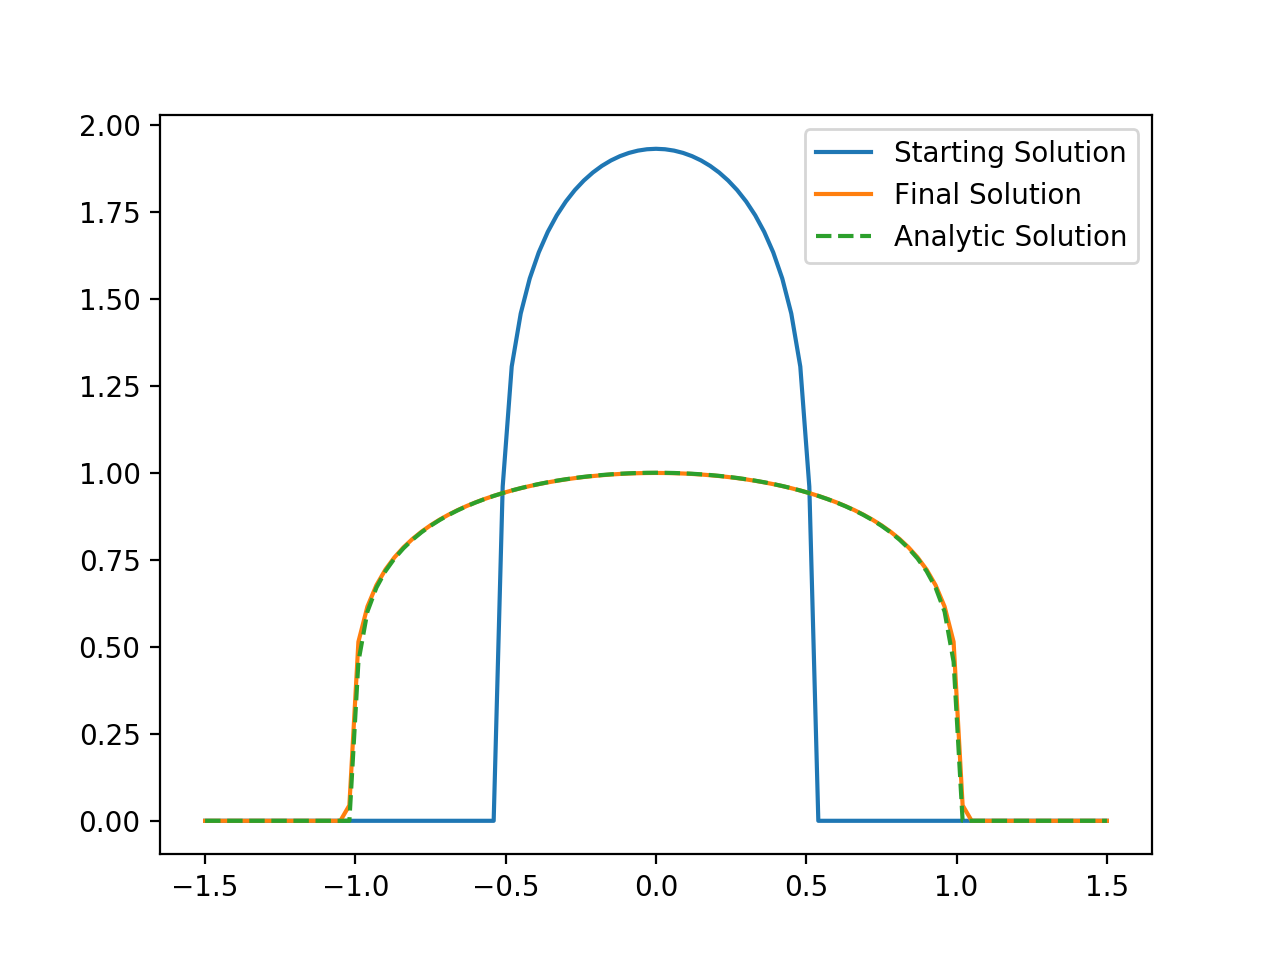

In [11]:
plt.figure()
plt.plot(x,bTemps[0], label='Starting Solution')
plt.plot(x,bTemps[-1], label='Final Solution')
plt.plot(x,barenblatt_nondim(bBeta,x,1.0),'--', label='Analytic Solution')
plt.legend()

# Conductive Flux Limiting
We adopt the form described in [Bradshaw & Cargill 2013](http://doi.org/10.1088/0004-637X/770/1/12) (Appendix) -- for electrons only. In this example we look at the temperature evolution in a slab of plasma with constant density ($n_e$). Decreasing this density, decreases the collisionality of the plasma, increasing its conductivity (as the mean free path increases). Units are CGS. In a complete system the problem will be slightly more non-linear as $n_e$ will not be constant, and alpha will therefore be an array too.

In [12]:
ne = 1e10 # electron density cm^{-3}

nGrid = 101
sigRange = 30 # Controls the steepness of the temperature transition, increase to make steeper.
z = np.linspace(0, 1e8, nGrid)
dz = z[1] - z[0]
# Initial temperature profile
temperature = (np.tanh(np.linspace(-sigRange, sigRange, nGrid)) + 1.0) / 4.0 + 0.1
temperature *= 1.55e7

# Physical parameters needed for simultaion
Gamma = 1.4
GammaM = Gamma - 1.0
Boltzmann = 1.3806e-16
Kappa0 = 1.1e-6
EleCv = Boltzmann * ne / GammaM

<IPython.core.display.Javascript object>


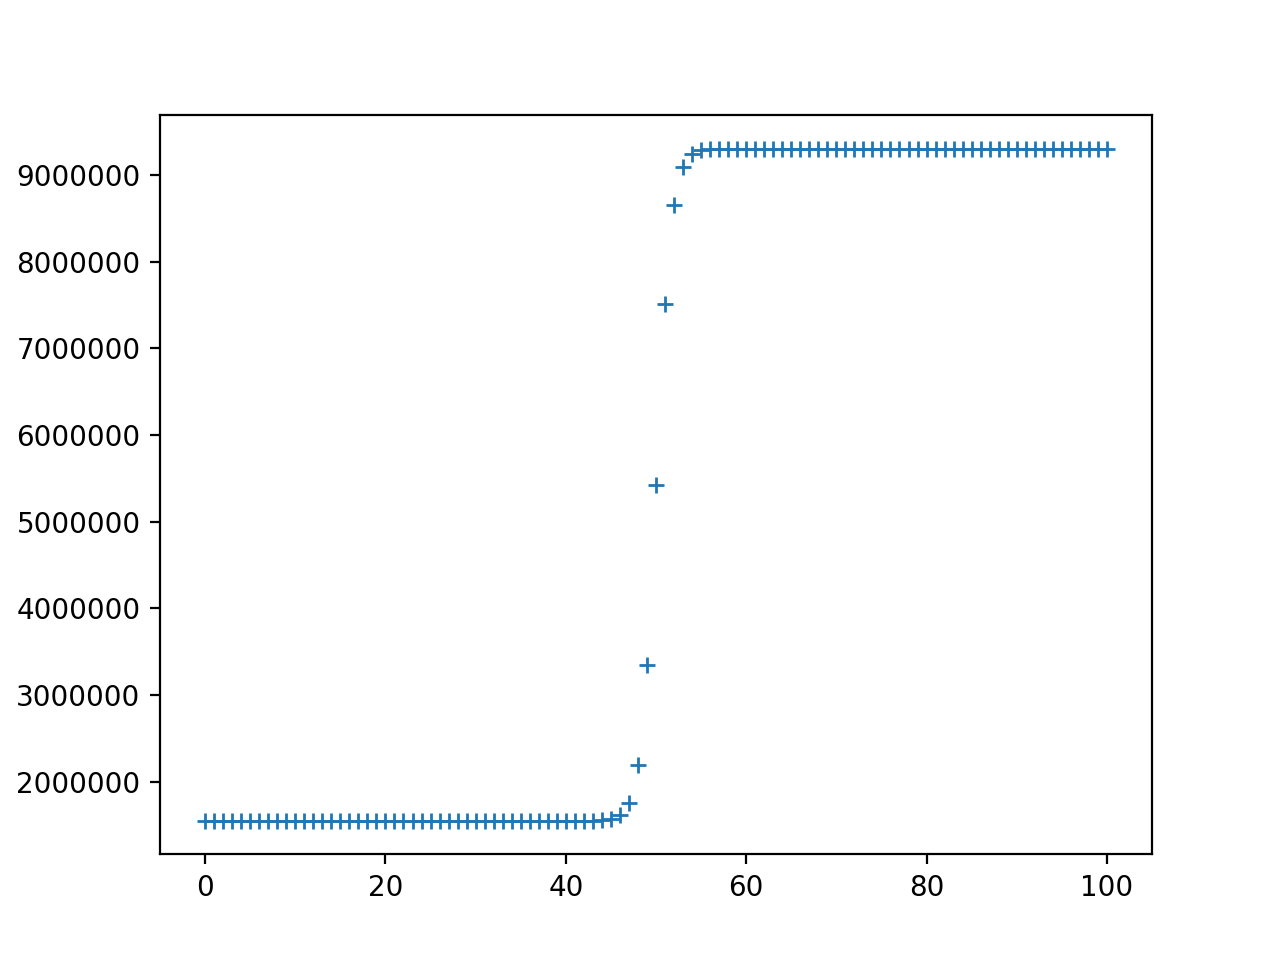

In [13]:
plt.figure()
plt.plot(temperature, '+')

In [14]:
@njit('float64[:](float64[:], float64, float64, float64)')
def compute_temperature_source(temperature, alpha, beta, kappa0):
    source = np.zeros_like(z)
    fCond = np.zeros_like(z)
    fSat = np.zeros_like(z)
    
    padded = np.zeros((1, temperature.shape[0] + 4))
    padded[0, 2:-2] = temperature
    padded[0, :2] = temperature[0]
    padded[0, -2:] = temperature[-1]
    tTilde = reconstruct_weno(padded)
    tTilde = tTilde[0, :, 2:-2]

    source[1:-1] = alpha / dz**2 * (kappa0 * tTilde[1,1:-1]**beta * 
                             (temperature[2:] - temperature[1:-1]) - 
                             kappa0 * tTilde[0,1:-1]**beta * 
                             (temperature[1:-1] - temperature[0:-2]))
    source[1:-1] += alpha / dz**2 * (kappa0 * tTilde[0,2:]**beta * 
                             (temperature[2:] - temperature[1:-1]) - 
                             kappa0 * tTilde[1,0:-2]**beta * 
                             (temperature[1:-1] - temperature[0:-2]))
    source *= 0.5

    return source

@njit('float64[:](float64[:], float64, float64, float64)')
def compute_temperature_limited(temperature, alpha, beta, kappa0):
    source = np.zeros_like(z)
    fCond = np.zeros_like(z)
    fSat = np.zeros_like(z)
    
    padded = np.zeros((1, temperature.shape[0] + 4))
    padded[0, 2:-2] = temperature
    padded[0, :2] = temperature[0]
    padded[0, -2:] = temperature[-1]
    tTilde = reconstruct_weno(padded)
    tTilde = tTilde[0, :, 2:-2]

    fCond[1:-1] = kappa0 * tTilde[1,1:-1]**beta * ((temperature[2:] - temperature[1:-1])) / dz
    fSat[1:-1] = 3 /( 2 * np.sqrt(9.1e-28)) * ne * (Boltzmann * tTilde[1, 1:-1])**1.5
    fCond = fCond * fSat / (np.sqrt(fCond**2 + fSat**2))
    
    source[1:-1] = fCond[1:-1]
    
    fCond[1:-1] = kappa0 * tTilde[0,1:-1]**beta * ((temperature[1:-1] - temperature[0:-2])) / dz
    fSat[1:-1] = 3 /( 2 * np.sqrt(9.1e-28)) * ne * (Boltzmann * tTilde[0, 1:-1])**1.5
    fCond = fCond * fSat / (np.sqrt(fCond**2 + fSat**2))
    
    source[1:-1] -= fCond[1:-1]
    
    fCond[1:-1] = kappa0 * tTilde[0, 2:]**beta * ((temperature[2:] - temperature[1:-1])) / dz
    fSat[1:-1] = 3 /( 2 * np.sqrt(9.1e-28)) * ne * (Boltzmann * tTilde[0, 2:])**1.5
    fCond = fCond * fSat / (np.sqrt(fCond**2 + fSat**2))
    
    source[1:-1] += fCond[1:-1]
    
    fCond[1:-1] = kappa0 * tTilde[1, 0:-2]**beta * ((temperature[1:-1] - temperature[0:-2])) / dz
    fSat[1:-1] = 3 /( 2 * np.sqrt(9.1e-28)) * ne * (Boltzmann * tTilde[1, 0:-2])**1.5
    fCond = fCond * fSat / (np.sqrt(fCond**2 + fSat**2))
    
    source[1:-1] -= fCond[1:-1]
    
    source *= 0.5 * alpha / dz
    
    return source


In [15]:
cBeta = 2.5
cAlpha = 1 / EleCv

initialTime = 0
cTemps = [temperature]
lTemps = [temperature]
Theta = 0.55
dt = 1e-4
currentTime = initialTime
start = time.time()
steps = int(np.ceil(0.1 / dt))
for s in tqdm(range(steps)):
#     print(currentTime)
    prevTemp = np.copy(cTemps[-1])
    prevTempLim = np.copy(lTemps[-1])
    
    def residual(temp):
        dPlus = compute_temperature_source(temp, cAlpha, cBeta, Kappa0)
        d = compute_temperature_source(prevTemp, cAlpha, cBeta, Kappa0)

        return temp - prevTemp - dt * ((Theta)*dPlus + (1.0 - Theta)*d)
    
    def residual_lim(temp):
        dPlus = compute_temperature_limited(temp, cAlpha, cBeta, Kappa0)
        d = compute_temperature_limited(prevTempLim, cAlpha, cBeta, Kappa0)

        return temp - prevTempLim - dt * ((Theta)*dPlus + (1.0 - Theta)*d)
    
    newTemp = newton_krylov(residual, prevTemp)
    newTempLim = newton_krylov(residual_lim, prevTempLim)
    cTemps.append(newTemp)
    lTemps.append(newTempLim)
    currentTime += dt
end = time.time()
print('Time taken: %f s, per step: %f s' % (end - start, (end-start)/(len(bTemps)-1)))


Time taken: 56.874464 s, per step: 0.028437 s


<IPython.core.display.Javascript object>


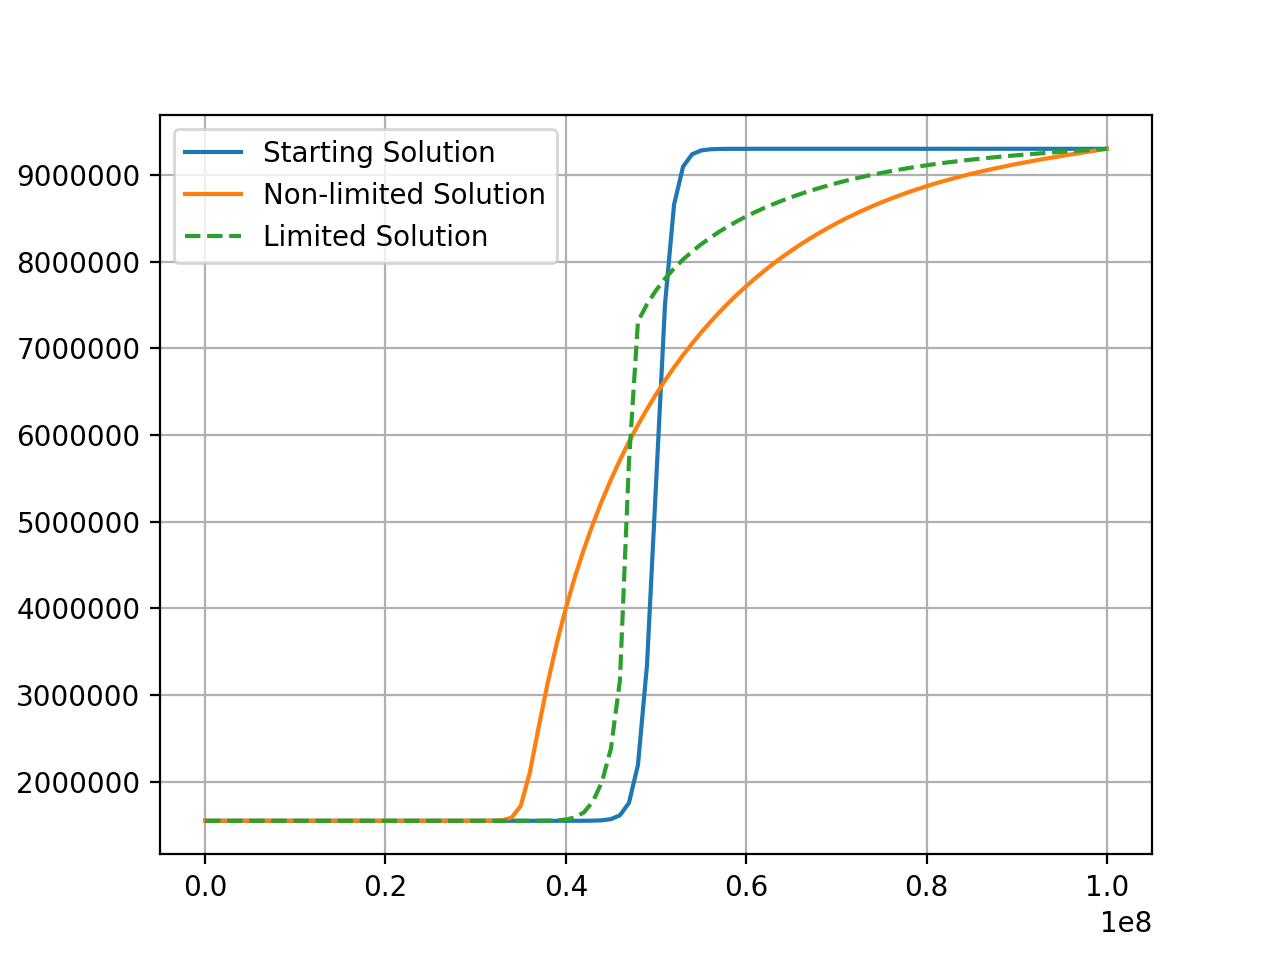

In [20]:
plt.figure()
plt.plot(z, cTemps[0], label='Starting Solution')
plt.plot(z, cTemps[40], label='Non-limited Solution')
plt.plot(z, lTemps[40], '--', label='Limited Solution')
plt.grid()
plt.legend()